In [51]:
import rasterio as rio
from cmr import CollectionQuery, GranuleQuery

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, mapping, shape

import ipywidgets as widgets
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import cartopy.io.img_tiles as cimgt

import requests
import os
from glob import glob
from tqdm import tqdm 
import math

from multiprocessing import Pool
import pickle
from planet import api

# ASO/Planet Available Imagery Footprint Analysis

Here we intend to quantify the spatial area ($\text{km}^2$) of all available Planet Labs imagery covering the ASO-flown regions. 

The steps to complete this process are as follows: 

1. Query the NASA Common Metadata Repository (CMR) for Airborne Snow Observatory (ASO) collects. 
1. Collect spatial area for all ASO regions. 
2. Query Planet Catalog API (via `porder`?) for all available imagery overlapping each ASO region. 
3. Sum spatial areas all imagery footprints. 

## ASO Catalog Search 

Below we use the NASA CMR to search for ASO collects. 

In [3]:
# Load the ASO Catalog
nasaAPI = GranuleQuery()
aso = pd.DataFrame(nasaAPI.short_name('ASO_3M_SD').get())
aso.head()

,producer_granule_id,time_start,updated,dataset_id,data_center,title,coordinate_system,day_night_flag,time_end,id,original_format,granule_size,browse_flag,polygons,collection_concept_id,online_access_flag,links
0,ASO_3M_SD_USCATB_20130403.tif,2013-04-03T00:00:00.000Z,2019-07-09T14:43:15.619Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848623,GEODETIC,UNSPECIFIED,2013-04-03T23:59:59.000Z,G1623914151-NSIDC_ECS,ECHO10,309.929,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
1,ASO_3M_SD_USCATB_20130429.tif,2013-04-29T00:00:00.000Z,2019-07-09T14:44:30.639Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848651,GEODETIC,UNSPECIFIED,2013-04-29T23:59:59.000Z,G1623914238-NSIDC_ECS,ECHO10,1133.05,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
2,ASO_3M_SD_USCATB_20130503.tif,2013-05-03T00:00:00.000Z,2019-07-09T14:44:00.613Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848643,GEODETIC,UNSPECIFIED,2013-05-03T23:59:59.000Z,G1623914198-NSIDC_ECS,ECHO10,1133.05,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
3,ASO_3M_SD_USCATB_20130525.tif,2013-05-25T00:00:00.000Z,2019-07-09T14:44:15.633Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848650,GEODETIC,UNSPECIFIED,2013-05-25T23:59:59.000Z,G1623914214-NSIDC_ECS,ECHO10,1133.05,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
4,ASO_3M_SD_USCATB_20130601.tif,2013-06-01T00:00:00.000Z,2019-07-09T14:44:00.636Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848644,GEODETIC,UNSPECIFIED,2013-06-01T23:59:59.000Z,G1623914150-NSIDC_ECS,ECHO10,1133.05,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...


In [4]:
## Parse into Useful Data

# Parse dates for easier sorting
aso.time_start = pd.to_datetime(aso.time_start)

# Store ASO region
aso['aso_region'] = [granId.split('_')[3] for granId in aso.producer_granule_id]

# Convert polygons into Shapely Polygons.
polygons = []
for raw_poly in aso.polygons.values:
    t = pd.to_numeric(raw_poly[0][0].split(" "))
    polygons.append(Polygon(list(zip(t[1::2], t[::2]))))
aso['geom'] = polygons

In [5]:
# Examine ASO regions by area. 

asoRegions = sorted(aso.aso_region.unique())
asoRegionsGeo = [(r, aso[aso.aso_region == r].geom.values[0]) for r in asoRegions]
asoRegionsGeo

[('USCAJW', <shapely.geometry.polygon.Polygon at 0x7f29be0095f8>),
 ('USCAKC', <shapely.geometry.polygon.Polygon at 0x7f29be0096a0>),
 ('USCAKN', <shapely.geometry.polygon.Polygon at 0x7f29be0096d8>),
 ('USCALB', <shapely.geometry.polygon.Polygon at 0x7f29be083eb8>),
 ('USCALV', <shapely.geometry.polygon.Polygon at 0x7f29be009208>),
 ('USCAMB', <shapely.geometry.polygon.Polygon at 0x7f29be009668>),
 ('USCARC', <shapely.geometry.polygon.Polygon at 0x7f29be009240>),
 ('USCARL', <shapely.geometry.polygon.Polygon at 0x7f29be009470>),
 ('USCASF', <shapely.geometry.polygon.Polygon at 0x7f29be0092e8>),
 ('USCASJ', <shapely.geometry.polygon.Polygon at 0x7f29be009320>),
 ('USCATB', <shapely.geometry.polygon.Polygon at 0x7f29be07cb70>),
 ('USCATE', <shapely.geometry.polygon.Polygon at 0x7f29be083cc0>),
 ('USCOCB', <shapely.geometry.polygon.Polygon at 0x7f29be083dd8>),
 ('USCOCJ', <shapely.geometry.polygon.Polygon at 0x7f29be083d68>),
 ('USCOGE', <shapely.geometry.polygon.Polygon at 0x7f29be00951

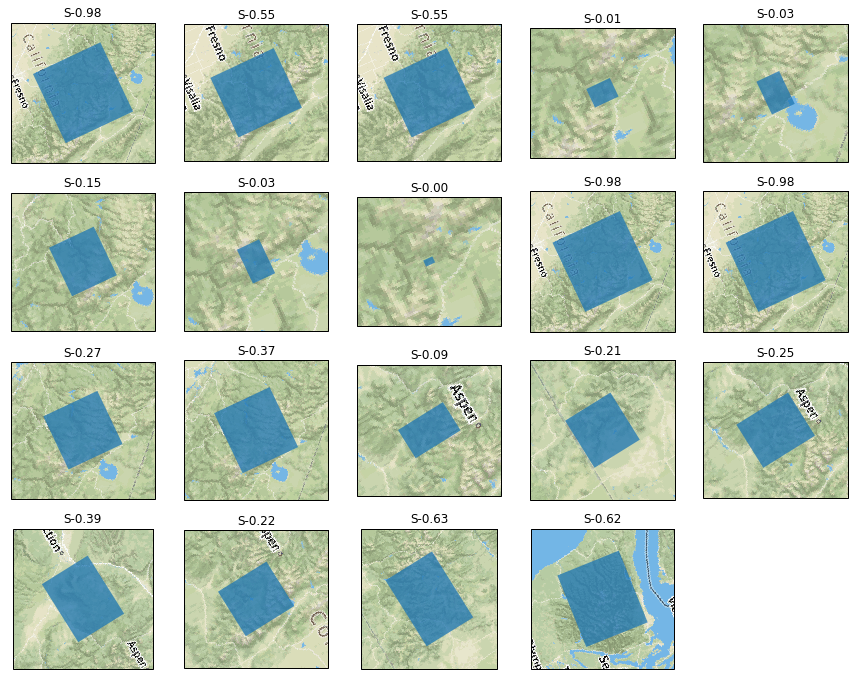

In [88]:
## Create figure of all ASO regions. 
## NOTE: This takes ~2-3 minutes to complete.
##       If there's already a figure below this cell, there's no need to run it. 

fig = plt.figure(figsize=(15, 15))
gs = plt.GridSpec(5, 5)

mapbox = cimgt.MapboxTiles(
    access_token="pk.eyJ1IjoiYWNhbm5pc3RyYSIsImEiOiJLWVM2RWhJIn0.TputXxRYBUPh-vjDg6_TFA", 
    map_id = 'streets'
)


for i, (region, geom) in enumerate(asoRegionsGeo):
    _a = plt.subplot(gs[i], projection=ccrs.AlbersEqualArea())
    _a.get_xaxis().set_visible(False)
    _a.get_yaxis().set_visible(False)
    _a.add_geometries([geom], crs=ccrs.PlateCarree(), alpha=0.76)
    _a.set_title("{}-{:.2f}".format(region[1], geom.area))
    bds = geom.buffer(0.2).bounds
    _a.set_extent([bds[0], bds[2], bds[1], bds[3]], crs = ccrs.PlateCarree())
    _a.add_image(mapbox, 7)
    

## Planet Catalog Search Infrastructure Testing

In [110]:
pl_client = api.ClientV1()

In [111]:
def _search(shapley_geom):
    f = api.filters.and_filter(
        api.filters.geom_filter(geom=mapping(shapley_geom)),
        api.filters.string_filter('instrument', 'PS2'),
        api.filters.string_filter('quality_category', 'standard')
    )
    items = ["PSScene4Band"]
    query = api.filters.build_search_request(f, items)
    ans = pl_client.quick_search(query, page_size = 250)
    
    items = []
    ids = []
    page = ans
    while page is not None:
        group = page.get()['features']
        items.extend(group)
        ids.extend([i['id'] for i in group])
        try:
            page = page.next()
        except Exception as e:
            print(e)
            break 
        print(len(set(ids)))
        
        
    return items

In [112]:
items = _search(asoRegionsGeo[3][1])


250
500
750
1000
1250
1500
1750
2000
2250
2500
2569
2569


In [115]:
items[0]

{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20191002_181917_1004',
  'assets': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20191002_181917_1004/assets/',
  'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSScene4Band/items/20191002_181917_1004/thumb'},
 '_permissions': ['assets.basic_analytic_rpc_nitf:download',
  'assets.udm2:download',
  'assets.analytic_xml:download',
  'assets.basic_analytic_dn:download',
  'assets.basic_analytic_dn_xml_nitf:download',
  'assets.basic_analytic_dn_nitf:download',
  'assets.basic_analytic_xml:download',
  'assets.basic_analytic_nitf:download',
  'assets.basic_analytic_rpc:download',
  'assets.analytic_dn:download',
  'assets.basic_udm:download',
  'assets.basic_analytic_dn_rpc_nitf:download',
  'assets.analytic:download',
  'assets.analytic_dn_xml:download',
  'assets.analytic_sr:download',
  'assets.basic_analytic_dn_xml:download',
  'assets.basic_udm2:download',
  'assets.basic_anal

In [113]:
items[0]['properties']['epsg_code']

32611

In [22]:
from functools import partial
import pyproj
from shapely.ops import transform

def _getProjector(src_epsg, dst_epsg):
    projector = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:{}'.format(src_epsg)), # source coordinate system
        pyproj.Proj(init='epsg:{}'.format(dst_epsg))) # destination coordinate system
    return(projector)

In [167]:
(transform(_getProjector(4326,32611) , shape(items[9]['geometry']).buffer(0))).area / 1e+6

208.7179214648062

In [161]:
props = [i['properties'] for i in items]
geoms = [shape(i['geometry'])   for i in items]
assets=  gpd.GeoDataFrame(pd.DataFrame.from_records(props), geometry = geoms)

assets.head()

,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,columns,epsg_code,ground_control,gsd,...,snow_ice_percent,strip_id,sun_azimuth,sun_elevation,updated,view_angle,visible_confidence_percent,visible_percent,usable_data,geometry
0,2019-10-01T21:08:35.891402Z,0.0,99.0,100.0,0.01,0.0,9366,32611,True,4.1,...,0.0,2718664,209.4,44.9,2019-10-02T02:18:36Z,2.0,99.0,100.0,NaN,POLYGON ((-119.0190186189953 37.52981125418886...
1,2019-10-01T21:08:34.789873Z,0.0,99.0,100.0,0.00,0.0,9376,32611,True,4.1,...,0.0,2718664,209.4,44.8,2019-10-02T02:18:30Z,2.0,87.0,100.0,NaN,POLYGON ((-119.0042026117115 37.58257557081116...
2,2019-10-01T21:08:33.688869Z,0.0,98.0,100.0,0.00,0.0,9376,32611,True,4.1,...,0.0,2718664,209.4,44.8,2019-10-02T02:18:46Z,2.0,84.0,100.0,NaN,POLYGON ((-118.9887695230136 37.63771630219583...
3,2019-10-01T18:22:19.471346Z,0.0,94.0,99.0,0.00,0.0,8870,32611,True,3.8,...,0.0,2718214,149.5,44.7,2019-10-02T03:58:44Z,5.0,71.0,100.0,NaN,POLYGON ((-118.9871525766208 37.55018709084236...
4,2019-10-01T18:22:18.432731Z,0.0,96.0,100.0,0.00,0.0,8897,32611,True,3.8,...,0.0,2718214,149.6,44.7,2019-10-02T03:59:05Z,4.9,70.0,100.0,NaN,POLYGON ((-118.9745539429011 37.59519891358216...


In [116]:
def queryRegion(regionName, regionGeometry):
    items = _search(regionGeometry)
    
    props = [i['properties'] for i in items]
    geoms = [shape(i['geometry'])   for i in items]
    ids = [i['id'] for i in items]
    assets= gpd.GeoDataFrame(pd.DataFrame.from_records(props), geometry = geoms)
    assets = assets.assign('area_km2', [transform(_getProjector(4326, i['epsg_code']), i.geometry).area / 1e+6 for _, i in assets.iterrows()])
    assets = assets.assign('id', ids)
    
    with open("{}-assets.pkl".format(regionName), 'wb') as jar:
        pickle.dump(assets, jar)
    
    


In [ ]:
ans = queryRegion(asoRegionsGeo[3][0], asoRegionsGeo[3][1])

In [ ]:
for region in asoRegionsGeo[1:]:
    queryRegion(region[0], region[1])

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750
15000
15250
15500
15750
16000
16250
16500
16750
17000
17250
17500
17750
18000
18250
18500
18750
19000
19250
19500
19750
20000
20250
20500
20750
21000
21250
21500
21750
22000
22250
22500
22750
23000
23250
23500
23750
24000
24250
24500
24750
25000
25250
25500
25750
26000
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750
15000
15250
15500
15750
16000
16250
16500
16750
17000
17250
17500
17750
18000
18250
18500
18750
19000
19250
19500
19750
20000
20250
2

In [1]:
!ls 

ASO_Planet_footprint.ipynb  USCAMB-assets.pkl  USCOCB-assets.pkl
tester.pkl		    USCARC-assets.pkl  USCOCJ-assets.pkl
USCAJW-assets.pkl	    USCARL-assets.pkl  USCOGE-assets.pkl
USCAKC-assets.pkl	    USCASF-assets.pkl  USCOGM-assets.pkl
USCAKN-assets.pkl	    USCASJ-assets.pkl  USCOGT-assets.pkl
USCALB-assets.pkl	    USCATB-assets.pkl  USCORG-assets.pkl
USCALV-assets.pkl	    USCATE-assets.pkl  USWAOL-assets.pkl


## Part 2: Compute Summaries

In [7]:
asset_files = glob("*-assets.pkl")
asset_files

['USCASJ-assets.pkl',
 'USWAOL-assets.pkl',
 'USCAKN-assets.pkl',
 'USCAJW-assets.pkl',
 'USCORG-assets.pkl',
 'USCAKC-assets.pkl',
 'USCALV-assets.pkl',
 'USCALB-assets.pkl',
 'USCOGE-assets.pkl',
 'USCARC-assets.pkl',
 'USCATB-assets.pkl',
 'USCOGT-assets.pkl',
 'USCOCJ-assets.pkl',
 'USCOGM-assets.pkl',
 'USCATE-assets.pkl',
 'USCAMB-assets.pkl',
 'USCARL-assets.pkl',
 'USCOCB-assets.pkl',
 'USCASF-assets.pkl']

In [14]:
allAssets = {}
for file in asset_files:
    region = file.split("-")[0]
    with open(file, 'rb') as af:
        allAssets[region] = pickle.load(af)

In [23]:
for region in allAssets.keys():
    allAssets[region]['area_km2'] = [transform(_getProjector(4326, i['epsg_code']), i.geometry).area / 1e+6 for _, i in allAssets[region].iterrows()]



In [15]:
allAssets.keys()

dict_keys(['USCASJ', 'USWAOL', 'USCAKN', 'USCAJW', 'USCORG', 'USCAKC', 'USCALV', 'USCALB', 'USCOGE', 'USCARC', 'USCATB', 'USCOGT', 'USCOCJ', 'USCOGM', 'USCATE', 'USCAMB', 'USCARL', 'USCOCB', 'USCASF'])

In [24]:
totalArea = sum([allAssets[k]['area_km2'].sum() for k in allAssets.keys()])

In [37]:
print("Total Area: {0:.2f} km2".format(totalArea))

Total Area: 62110892.72 km2


### Compute AOI-clipped area?

In [61]:
regionGeoms = {r : g for r, g in asoRegionsGeo}
clippedAssets = {}


def _croppedgeoms(region):
    region_geom = regionGeoms[region]
    croppedAssetGeoms = [a.geometry.intersection(region_geom) for _, a in allAssets[region].iterrows()]
    return (region, croppedAssetGeoms)
    

In [62]:
pp = Pool()
a = pp.map(_croppedgeoms, allAssets.keys())

In [102]:
totalClipped = 0
for region, clips in a:
    totalClipped += sum([
        transform(_getProjector(4326, allAssets[region].epsg_code.values[0]), c).area / 1e+6 for
        c in clips
    ])


In [109]:
clippedDiff = totalArea - totalClipped
print("Total Assets: {0:,.2f} km2".format(totalArea))
print("Total Clipped Assets: {0:,.2f} km2".format(totalClipped))
print("Total assets - clipped assets: {0:,.2f} km2".format(clippedDiff))

Total Assets: 62,110,892.72 km2
Total Clipped Assets: 36,560,525.00 km2
Total assets - clipped assets: 25,550,367.72 km2
